## Ejercicio 04.- Clasificador Spamless (2da oportunidad)

Instrucciones, reutilizar el caso de estudio de la semana 2 (Clasificador Spamless) que se desarrolló en clase y mejorar el Score de clasificación de manera libre:

Opciones:
- Puedes filtrar StopWords (No se filtraron en el código original del clasificador)
- Puedes crear N-Gramas artificiales (Reemplazando en el texto original por ejemplo las palabras "último día" por "ultimo-dia", para que cuando éstas sean analizadas cuenten como un solo bigrama en las características extraidas (Asegurate que el proceso de tokenización no vuelva a deshacer los bigramas o trigramas, etc...).
PD: Si generas bigramas específicos, también deberás de hacer la conversión cuando se ingrese un nuevo texto a evaluar (Entradas para pruebas)
- Puedes implementar lematización (Ésto también se tendría que hacer en las entradas de las pruebas, o en la información que se utilice para validar el modelo)
- Puedes utilizar nuevas características como entrada a tu modelo, por ejemplo, agregar en a matriz de Bag of Words valores como la cantidad de caracteres, la cantidad de veces que aparece cierta PoS (Elemento del discurso), la cantidad de signos de puntuación, o lo que creas conveniente.

Enviar en la primera celda de tu código, los elementos que decidiste agregar para mejorar el análisis del clasificador

Presentar al final la matriz de confusión y métricas que se vieron en clase (Precisión, Sensibilidad y F1)

Suerte con el desarrollo, con este ejercicio ya eres todo un diseñador de PLN.

In [39]:
# Importar las librerías de que nos ayudarán a obtener la información, organizarla y procesarla
import pandas as pd

In [40]:
# Lectura del archivo que contiene el corpus con la información clasificada
# y preprocesada (Ham VS Spam)
df2 = pd.read_csv('Spamless_DataSet_CSV.csv')
df2.head(20) 

# Referencia para la lectura de archivos en: https://codeday.me/es/qa/20190412/477724.html

,clase,mensaje
0,NoSpam,Acuerdo para la reunión de planeación
1,NoSpam,[IMPORTANTE] Cambio de hora en la cita de mañana
2,NoSpam,Envio de información solicitada
3,NoSpam,Problema de autenticación resuelto
4,NoSpam,Activación correcta de tu cuenta
5,NoSpam,Fotos para enviar
6,NoSpam,Recibo del curso para escanear
7,NoSpam,Datos de las cuentas de acceso
8,NoSpam,Confirmación de proceso de Autovinculación
9,NoSpam,Confirmación de Activación de Cuenta en App Móvil


In [41]:
# Para detectar si tenemos filas vacías
print("Tamaño del data frame: " + str(len(df2)))
print("Cantidad de filas vacías:")
print(df2.isnull().sum())

# Eliminamos las filas vacías y vemos el tamaño del nuevo df
df2 = df2.dropna()
df2 = df2[df2['mensaje'] != ""]
print("\nTamaño del data frame sin vacíos: " + str(len(df2)))

Tamaño del data frame: 88
Cantidad de filas vacías:
clase      0
mensaje    0
dtype: int64

Tamaño del data frame sin vacíos: 88


In [42]:
# Verificar cuales son las clasificaciones que tenemos en nuestro DataSet
print("Clases que tenemos en el DataSet:")
print(df2['clase'].unique())

# Revisamos la cantidad de ejemplos que tenemos por cada clase
print("\nCantidad de ejemplos que tenemos por clase:")
print(df2['clase'].value_counts())

Clases que tenemos en el DataSet:
['NoSpam' 'Spam']

Cantidad de ejemplos que tenemos por clase:
Spam      60
NoSpam    28
Name: clase, dtype: int64


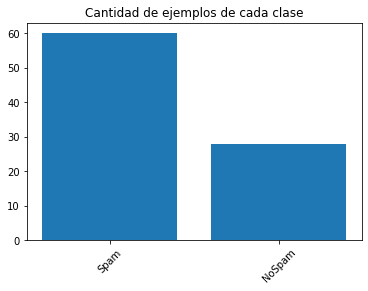

In [43]:
# Ploteamos la cantidad de ejemplos que tenemos de cada clase
# para ver si esta se encuentra balanceada o no
import matplotlib.pyplot as plt

Totales = df2['clase'].value_counts()
plt.bar(['Spam', 'NoSpam'], Totales)
plt.xticks(rotation = 45)
plt.title('Cantidad de ejemplos de cada clase') 
plt.show()

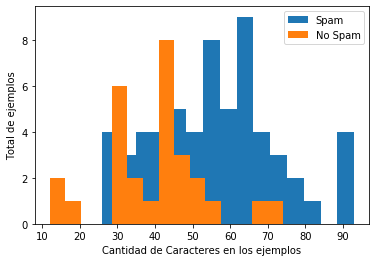

In [44]:
# Para analizar la información, ploteamos un histograma
# que nos indica la frecuencia de caracteres tanto en 
# Ham como en Spam para revisar su comportamiento

Spams = []
NoSpams = []
for clase, mensaje in zip(df2['clase'], df2['mensaje']):
    if clase == 'Spam':
        Spams.append(len(mensaje))
    else:
        NoSpams.append(len(mensaje))


plt.hist(Spams, bins=15)
plt.hist(NoSpams, bins=15)
plt.legend(['Spam', 'No Spam'])
plt.xlabel('Cantidad de Caracteres en los ejemplos') 
plt.ylabel('Total de ejemplos') 
plt.show()


    Error: Couldn't link model to 'es_core_news_sm'
    Creating a symlink in spacy/data failed. Make sure you have the required
    permissions and try re-running the command as admin, or use a
    virtualenv. You can still import the model as a module and call its
    load() method, or create the symlink manually.

    C:\Users\Irving\Miniconda3\envs\pln_2\lib\site-packages\es_core_news_sm
    -->
    C:\Users\Irving\Miniconda3\envs\pln_2\lib\site-packages\spacy\data\es_core_news_sm


    Creating a shortcut link for 'en' didn't work (maybe you don't have
    admin permissions?), but you can still load the model via its full
    package name: nlp = spacy.load('{name}')
    Download successful but linking failed



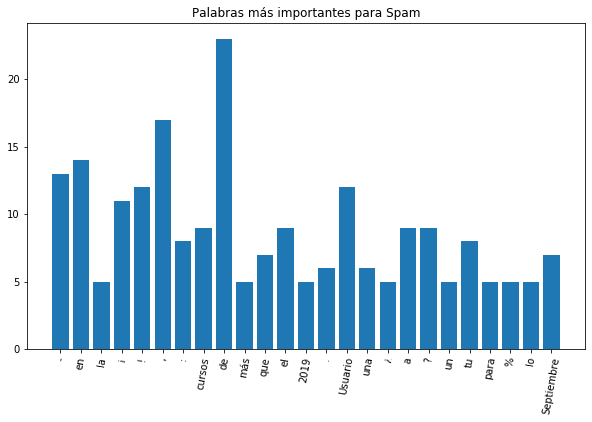

In [45]:
# Importamos el núcleo de trabajo para hacer la tokenización
import spacy.cli
spacy.cli.download('es_core_news_sm')
nlp_es = spacy.load('es_core_news_sm')

# Gráfica de los tokens más utilizados para Spam
Palabras_Spam = {}

for clase, mensaje in zip(df2['clase'], df2['mensaje']):
    if clase == 'Spam':
        for token in nlp_es(mensaje):
            if(Palabras_Spam.get(token.text) == None):
                Palabras_Spam.setdefault(token.text, 1)
            else:
                Palabras_Spam[token.text] += 1

Palabras_Spam2 = {}
for clave, valor in zip(Palabras_Spam.keys(), Palabras_Spam.values()):
    if(valor >= 5):
        Palabras_Spam2.setdefault(clave, valor)

plt.figure(figsize=(10,6))
plt.bar(Palabras_Spam2.keys(), Palabras_Spam2.values())
plt.title('Palabras más importantes para Spam') 
plt.xticks(rotation=80)
plt.show()

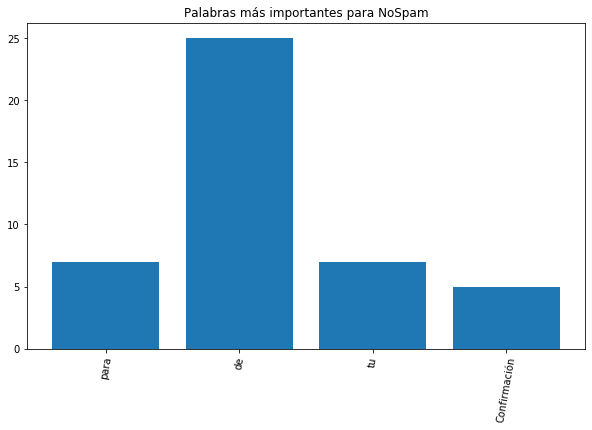

In [46]:
# Gráfica de los tokens más utilizados para No Spam
Palabras_NoSpam = {}

for clase, mensaje in zip(df2['clase'], df2['mensaje']):
    if clase == 'NoSpam':
        for token in nlp_es(mensaje):
            if(Palabras_NoSpam.get(token.text) == None):
                Palabras_NoSpam.setdefault(token.text, 1)
            else:
                Palabras_NoSpam[token.text] += 1

Palabras_NoSpam2 = {}
for clave, valor in zip(Palabras_NoSpam.keys(), Palabras_NoSpam.values()):
    if(valor >= 5):
        Palabras_NoSpam2.setdefault(clave, valor)

plt.figure(figsize=(10,6))
plt.bar(Palabras_NoSpam2.keys(), Palabras_NoSpam2.values())
plt.title('Palabras más importantes para NoSpam') 
plt.xticks(rotation=80)
plt.show()

## Preprocesamiento de la información

In [63]:
# Lematización de las palabras y filtrado de StopWords

# Asignación de StopWords predefinidas para idioma Español
import nltk
from nltk.corpus import stopwords
stop_words = nltk.corpus.stopwords.words('spanish')

for i in range(len(df2['mensaje'])):
    Texto = ""
    for token in nlp_es(df2['mensaje'][i]):
        if token.text not in stop_words:
            Texto = Texto + token.text + " "
    df2['mensaje'][i] = Texto

In [64]:
df2

,clase,mensaje
0,NoSpam,Acuerdo parir reunión planeación
1,NoSpam,[ IMPORTANTE ] Cambio hora citar mañana
2,NoSpam,Envio información solicitar
3,NoSpam,Problema autenticación resolver
4,NoSpam,Activación correcto contar
...,...,...
83,Spam,"Hoy ser día cualquiera , ¡ aquí catálogo cursa..."
84,Spam,"Apréndelo ahora , dejar parir luego . Echa vis..."
85,Spam,No perder lugar - Curso Machine Learning Práct...
86,Spam,Has aparecer 10 búsqueda semanal


In [65]:
# Separar la información (Dataset) en conjuntos de entrenamiento y validación

# Importar la librería de Sklearn
from sklearn.model_selection import train_test_split

# Definimos nuestra información (Nombre de la clase (Y) y valor (X))
X = df2['mensaje']
Y = df2['clase']

# Segmentamos la información en conjuntos de entrenamiento y de validación (80 / 20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [66]:
# Se importa la librería para extraccion de características y vectorización 
# de los ejemplos usando la función CountVectorizer()
# (Permite conocer información de los daros de entrenamiento)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

#  Con esta línea se construye un diccionario (Vocabulario de palabras) y se 
# cuenta el número de palabras que hay para cada elemento del diccionario
X_train_counts = count_vect.fit_transform(X_train)

# (Shape) El primer número representa los mensajes, y el segundo el vocabulario usado
X_train_counts.shape

(70, 275)

In [67]:
# Se crea un Pipeline para asignar la secuencia de procesos
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# En el Pipeline se mete en un arreglo la secuencia de pasos que se desea
# seguir, o elementos que se desea enviar, en este caso 1) Vector de Tf-idf
# 2) El modelo LinearSVC 
# En esta línea se hace la vectorización y se ejecuta el clasificador en un solo paso
clasificador_Texto = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC())])

In [68]:
# Visualizamos los parámetros de nuestro modelo
print(clasificador_Texto.get_params().keys())

# Podemos cambiar algunos de los parámetros como por ejempplo, uso de minúsculas
# filtrado de stopwords y máximo de características a usar
clasificador_Texto.set_params(tfidf__lowercase=True, tfidf__stop_words=['de', 'para'], tfidf__max_features=None)

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__loss', 'clf__max_iter', 'clf__multi_class', 'clf__penalty', 'clf__random_state', 'clf__tol', 'clf__verbose'])


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['de', 'para'], strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
     

In [69]:
clasificador_Texto.fit(X_train, Y_train)
Predicciones = clasificador_Texto.predict(X_test)
print(X_test)
print(Predicciones)

86                    Has aparecer 10 búsqueda semanal 
17                  Este ser link confirmación correar 
71            Estudia Reino Unido - sesión informativo 
2                          Envio información solicitar 
13                  Solicitud parir cambiar contraseña 
32    Pensamos poder gustarte cursar sobrar Informát...
64           Estreno viernes 13 Septiembre ... Monarca 
74                 Usuario : ¿ ser hora hacer viajar ? 
9             Confirmación Activación Cuenta App Móvil 
85    No perder lugar - Curso Machine Learning Práct...
80    ¡ Triunfa cursar informático software sólo MX$...
66    Announcing 50,000 Bertelsmann Technology Schol...
24                                          ( asunto ) 
26              Por favor , finalizar registrar evento 
50             Ready to take off the training wheels ? 
41         ¡ Flash Sale terminar 24 hora ! Ahorra 70 % 
10    Por si interesar : Vacante parir Becario proye...
70    Llegó momento . ¡ Los descontar Septiembre

In [70]:
clasificador_Texto.predict(["Gracias por cofirmar tu asistencia", 
                            "Hola usuario, tenemos una oferta para tí",
                            "Solo por hoy, el precio ha bajado",
                            "Esperamos que te encuentras bien, ya hemos hecho la activación de tu cuenta",
                            "Porqué no revisas estos ofertones??",
                            "Mantequilla"])

array(['NoSpam', 'Spam', 'Spam', 'Spam', 'Spam', 'Spam'], dtype=object)

In [71]:
# Matriz de confusión y Métricas de evaluación del modelo
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# Impresión de matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(Y_test, Predicciones))

# Impresión de procentaje de Accuracy del modelo
print("\nAccuracy del modelo: ")
print(metrics.accuracy_score(Y_test, Predicciones))

# Impresión de las métricas para el modelo
print("\nMétricas de evaluación:")
print(classification_report(Y_test, Predicciones))

Matriz de confusión:
[[ 5  2]
 [ 0 11]]

Accuracy del modelo: 
0.8888888888888888

Métricas de evaluación:
              precision    recall  f1-score   support

      NoSpam       1.00      0.71      0.83         7
        Spam       0.85      1.00      0.92        11

    accuracy                           0.89        18
   macro avg       0.92      0.86      0.88        18
weighted avg       0.91      0.89      0.88        18

